In [21]:
import pandas as pd
import matplotlib.pyplot as plt

In [22]:
df = pd.read_csv("BTC.csv", index_col=0, parse_dates=True)
df.head()

,open,high,low,close,volume
2024-12-07,99885.37,100583.27,99012.73,99929.32,4774.350878
2024-12-08,99919.20,101435.05,98729.66,101174.99,4230.352252
2024-12-09,101175.00,101290.73,94220.80,97324.81,20103.050735
2024-12-10,97330.66,98338.17,94273.38,96660.76,20620.538775
2024-12-11,96660.75,101984.98,95722.79,101202.11,21190.237533


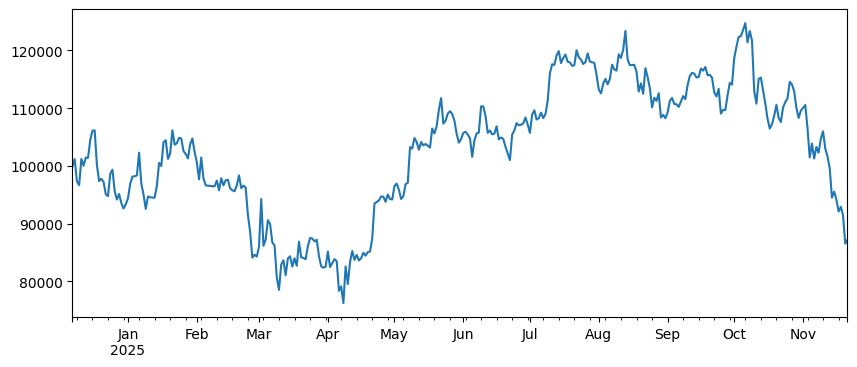

In [23]:
fig, ax = plt.subplots(figsize=(10, 4))
df["close"].plot(ax=ax)
plt.show()

#### Creating the strategy

In [24]:
def compute_support_resistance(df, window=20, shift_levels=1):
    df = df.copy()
    #Rolling low and high of closing prices
    df["support"] = df["close"].rolling(window=window, min_periods=1).min()
    df["resistance"]= df["close"].rolling(window=window, min_periods=1).max()

    #Shift levels forward to avaoid using future information

    df["support"] = df["support"].shift(shift_levels)
    df["resistance"] = df["resistance"].shift(shift_levels)
    return df

df = compute_support_resistance(df)

In [25]:
df

,open,high,low,close,volume,support,resistance
2024-12-07,99885.37,100583.27,99012.73,99929.32,4774.350878,NaN,NaN
2024-12-08,99919.20,101435.05,98729.66,101174.99,4230.352252,99929.32,99929.32
2024-12-09,101175.00,101290.73,94220.80,97324.81,20103.050735,99929.32,101174.99
2024-12-10,97330.66,98338.17,94273.38,96660.76,20620.538775,97324.81,101174.99
2024-12-11,96660.75,101984.98,95722.79,101202.11,21190.237533,96660.76,101174.99
...,...,...,...,...,...,...,...
2025-11-17,94182.03,95950.00,91158.35,92100.60,13319.956338,94183.97,112906.75
2025-11-18,92100.60,93775.00,89183.48,92914.46,16182.467229,92100.60,110536.01
2025-11-19,92914.45,92948.00,88483.12,91461.60,15642.233203,92100.60,110536.01
2025-11-20,91465.04,93080.91,85980.70,86536.88,18857.801349,91461.60,110536.01


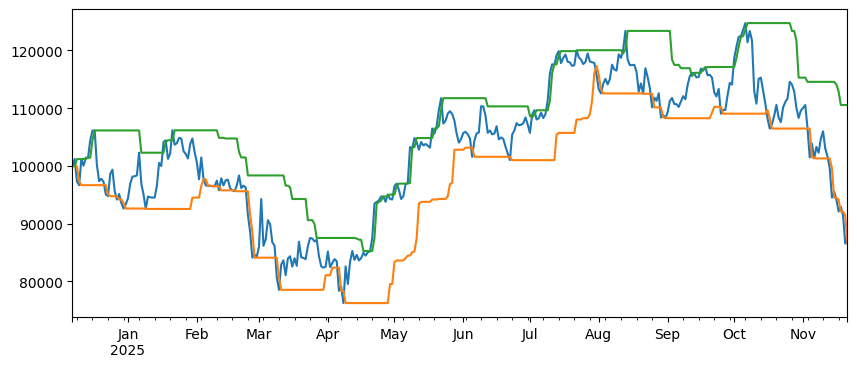

In [26]:
fig, ax = plt.subplots(figsize=(10, 4))
df["close"].plot(ax=ax)
df["support"].plot(ax=ax)
df["resistance"].plot(ax=ax)
plt.show()